In [ ]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import notebook_helper
import imodelsx.process_results
import sys
sys.path.append('../experiments/')
# results_dir = '../results/feb12_fmri_sweep/'
results_dir = '../results/feb12_fmri_sweep_gen_template1/'

In [ ]:
r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)

In [3]:
# display full strings
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):

    display(
        r
        .sort_values(by='top_score_synthetic', ascending=False)
        .filter(['top_score_synthetic', 'top_explanation_init_strs', 'explanation_init_ngrams', 'module_num', 'fmri_test_corr'])
        # .filter(['top_explanation_init_strs', 'explanation_init_ngrams', 'top_strs_added'])
        # .filter(['explanation_init_strs', 'explanation_init_ngrams',])
        .head(n=20)
        .round(3)
    )

,top_score_synthetic,top_explanation_init_strs,explanation_init_ngrams,module_num,fmri_test_corr
188,0.051,movement or action,"[started playing, up in new, grew up in, was replications of, was going to, is going to, up in two, started to scream, story begins in, up in dartmouth, up in providence, are going to, went to high, trained to eject, was not going, grew up on, grew up near, item originated from, thought yeah yeah, really dismayed to, started to sound, is triggered by, finally went to, went off, really should come, really started in, started to say, played with us, just heading for, was ready to, lives in texas, played college, actually lost, begins in in, got married in, up in oklahoma, joined the army, were going to, was expected to, parole aw yeah, ready to do, ready to uh, popped on impact, was born, day yeah it, supposed to start, joined the gym, flexibility mary kay, probably going to, ended slightly different, landed in brooklyn, was really tempted, is actually thinking, are able to, was really dismayed, appears out of, going to be, sudden insanely i, down in in, can can drive, went to talk, can start to, arrived on on, in dartmouth, was replications, tricia you know, can study, based modes, started writing about, wanted to ask, on repeat just, had played college, dropped out of, used to live, not going to]",143,0.628
178,0.050,interaction between two or more people,"[turned to me, turns to me, president looks into, she had this, some pubis sticking, says tricia, problem she, been raised that, and says tricia, he s he, i had this, she bought that, i turned to, sources the the, president put in, shy was cause, pokes her head, the church, that caught my, shy was, other things that, really frustrated him, pubis sticking out, he turns to, says to, that worried because, shit and he, said to, says to me, shit so she, president gives me, he had this, turned to my, i turn around, introduces herself and, shrink looks at, tricia you really, she she, zero there was, from guy to, panties and a, guy had a, sarah came to, navy and marine, law came over, things and military, panties and, showalter turns to, have an affair, had a daughter, men to, that also meant, therapist came in, occurs to me, closets and two, married have kids, she got this, have a daughter, know looked at, on one hand, back to that, sources the, took a deep, problem was, rudy leaves and, security was, other things, lie but she, they looked at, two closets and, rudy comes into, i ignored which, things up and, looks over at, of altercation]",119,0.635
42,0.048,"""um.""","[in the leg, um mm mm, and and um, do drum, um and um, to draw, how to draw, in between um, um and and, cliche um image, around and um, in other words, and um and, lothario, bla and um, be and um, who does the, playing an instrument, it was odd, artists model, how the hell, um mollify the, what the financial, halt um despite, in bars, i 'd rather, and imitate because, um or in, doing my modeling, play the guitar, the hell did, off or anything, to um mollify, do drum circles, for that matter, in um she, ground and and, for exercise, um mm, whatever may, 's most popular, be that certain, and um do, the for um, um mollify, mean and and, was and and, model um and, is is is, she films the, sign and as, when as, and um, tennis rackets, were are and, great what 's, glastonbury festival in, how the heck, as a ski, between um her, ls ) in, out and um, is is, why the fuck, to um rufisque, downhill main, - e, wha fuck why, what was the, dates in college, how to play, the andy warhol, wait i i, artists model starts, cockerels um and]",124,0.633
199,0.045,"people and activities, such as orthopedist, confidant, conscientious objector, women, make up, and calligrapher","[another orthopedist, orthopedist, another orthopedist whom, orthopedist whom, confidant, to another orthopedist, unannounced, styrofoam plate, unsent greeting cards, who 's paroled, photosensitive epilepsy, styrofoam, a confidant, up unanno

In [12]:
r.keys()

Index(['subsample_frac', 'checkpoint', 'checkpoint_module', 'seed', 'save_dir',
       'module_name', 'module_num', 'method_name', 'num_top_ngrams',
       'num_summaries', 'num_synthetic_strs', 'use_cache', 'save_dir_unique',
       'fmri_test_corr', 'explanation_init_ngrams', 'explanation_init_strs',
       'explanation_init_rationales', 'strs_added', 'strs_removed',
       'score_synthetic', 'top_explanation_init_strs', 'top_strs_added',
       'top_strs_removed', 'top_score_synthetic'],
      dtype='object')

/home/chansingh/.embgam/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


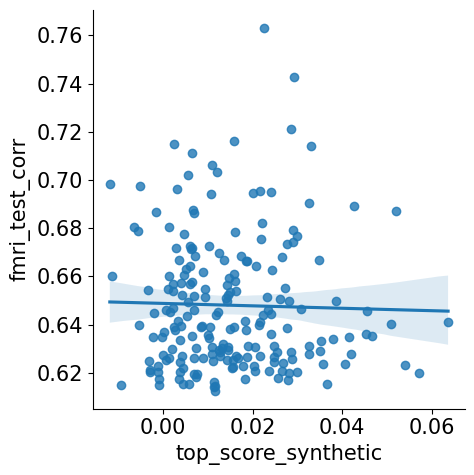

In [14]:
sns.lmplot(x='top_score_synthetic', y='fmri_test_corr', data=r)
plt.show()